In [1]:
import logging
import numpy as np
import os
import pandas as pd
import pickle
import re
import tensorflow as tf

from io import StringIO
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.utils import plot_model, to_categorical
from pathlib import Path
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.layers import Embedding


## Datos

In [2]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [3]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario

In [4]:
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [5]:
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()    
    txt.replace("\'d", " had")
    txt.replace("\'s", " is")
    txt.replace("\'m", " am")
    txt.replace("don't", "do not")
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de filas utilizadas:", len(input_sentences))

Cantidad de filas utilizadas: 6033


In [6]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

## Preprocesamiento

In [7]:
# Definimos el tamaño maximo del vocabulario
MAX_VOCAB_SIZE = 8000

In [8]:
# Realizamos la tokenizacion de las palabras
# Creamos un unico tokenizaor en Ingles 
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+,-./:;=¿?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(["<sos>", "<eos>"] + input_sentences + output_sentences + output_sentences_inputs)
input_integer_seq = tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = tokenizer.word_index
print(f"Cantidad de palabras en el vocabulario: {len(word2idx_inputs)}")

max_input_len = max(len(sentence) for sentence in input_integer_seq)
print(f"Oración de entrada más larga: {max_input_len}")

Cantidad de palabras en el vocabulario: 2157
Oración de entrada más larga: 9


In [9]:
output_integer_seq = tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = tokenizer.word_index
num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 
# Se suma 1 para incluir el token de palabra desconocida

max_out_len = max(len(sen) for sen in output_integer_seq)
print("Oración de salida más larga:", max_out_len)

Oración de salida más larga: 10


In [10]:
max_input_len = 16
max_out_len = 18

In [11]:
print(f"Cantidad de filas del dataset: {len(input_integer_seq)}")

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print(f"Encoder Input Sequences shape: {encoder_input_sequences.shape}")

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print(f"Decoder Input Sequences shape: {decoder_input_sequences.shape}")

Cantidad de filas del dataset: 6033
Encoder Input Sequences shape: (6033, 16)
Decoder Input Sequences shape: (6033, 18)


In [12]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(6033, 18, 2158)

## Embeddings

In [13]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [15]:
class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [16]:
model_embeddings = GloveEmbeddings()

In [17]:
print('Preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)

print(f"Numero de Embeddings nulos de palabras: {np.sum(np.sum(embedding_matrix**2, axis=1) == 0)}")

Preparing embedding matrix...
Numero de Embeddings nulos de palabras: 44


In [18]:
embedding_matrix.shape

(2157, 50)

## Entrenamiento del Modelo

In [19]:
max_input_len

16

In [20]:
n_units = 128

# define training encoder
encoder_inputs = Input(shape=(max_input_len,))

#encoder_embedding_layer = Embedding(num_words, EMBEDDING_SIZE, weights=[embedding_matrix], input_length=max_input_len)

encoder_embedding_layer = Embedding(
          input_dim=nb_words,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=max_input_len, # tamaño máximo de la secuencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 16)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 18)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 16, 50)    │    107,850 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 18, 128)   │    276,224 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 128),     │     91,648 │ embedding[0][0]   │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 18, 128), │    131,584 │ embedding_1[0][0… │
│                     │ (None, 128),      │            │ lstm[0][1],       │
│                     │ (None, 128)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 18, 2158)  │    278,382 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 885,688 (3.38 MB)

 Trainable params: 777,838 (2.97 MB)

 Non-trainable params: 107,850 (421.29 KB)

Note: you may need to restart the kernel to use updated packages.


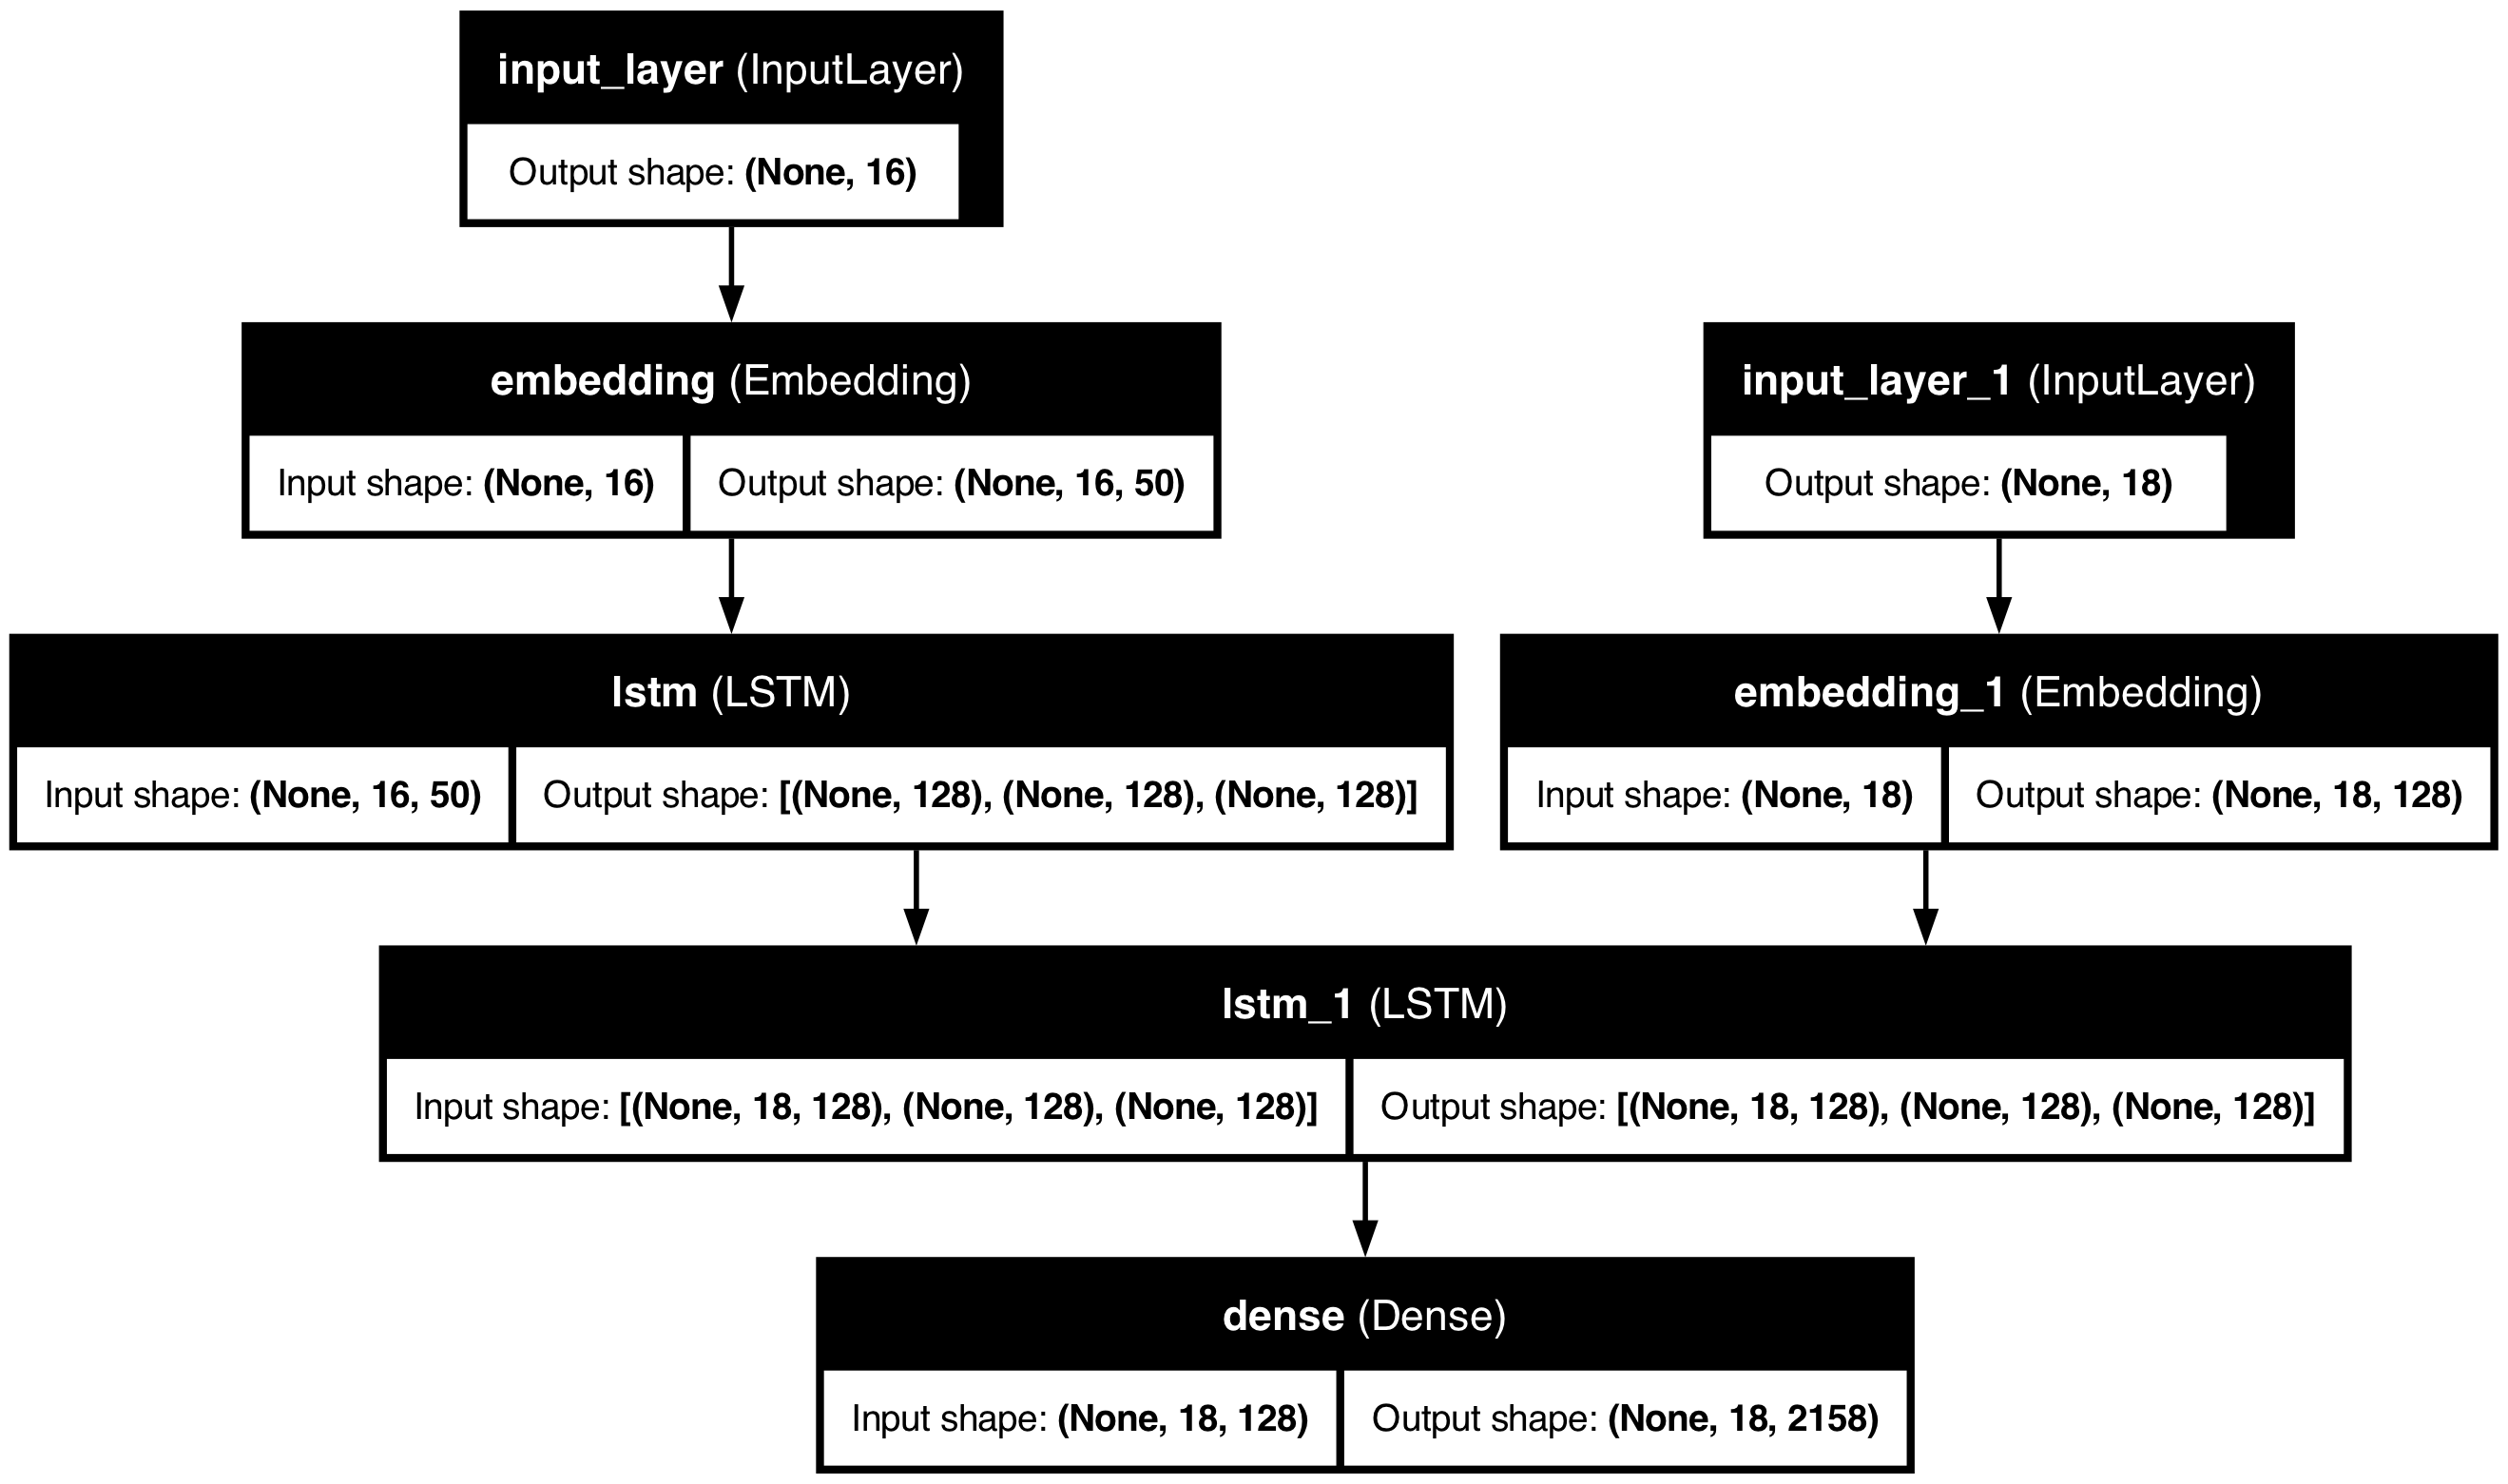

In [21]:
%pip install pydot
from tensorflow.keras.utils import plot_model
# Modelo completo (encoder+decoder) para poder entrenar
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

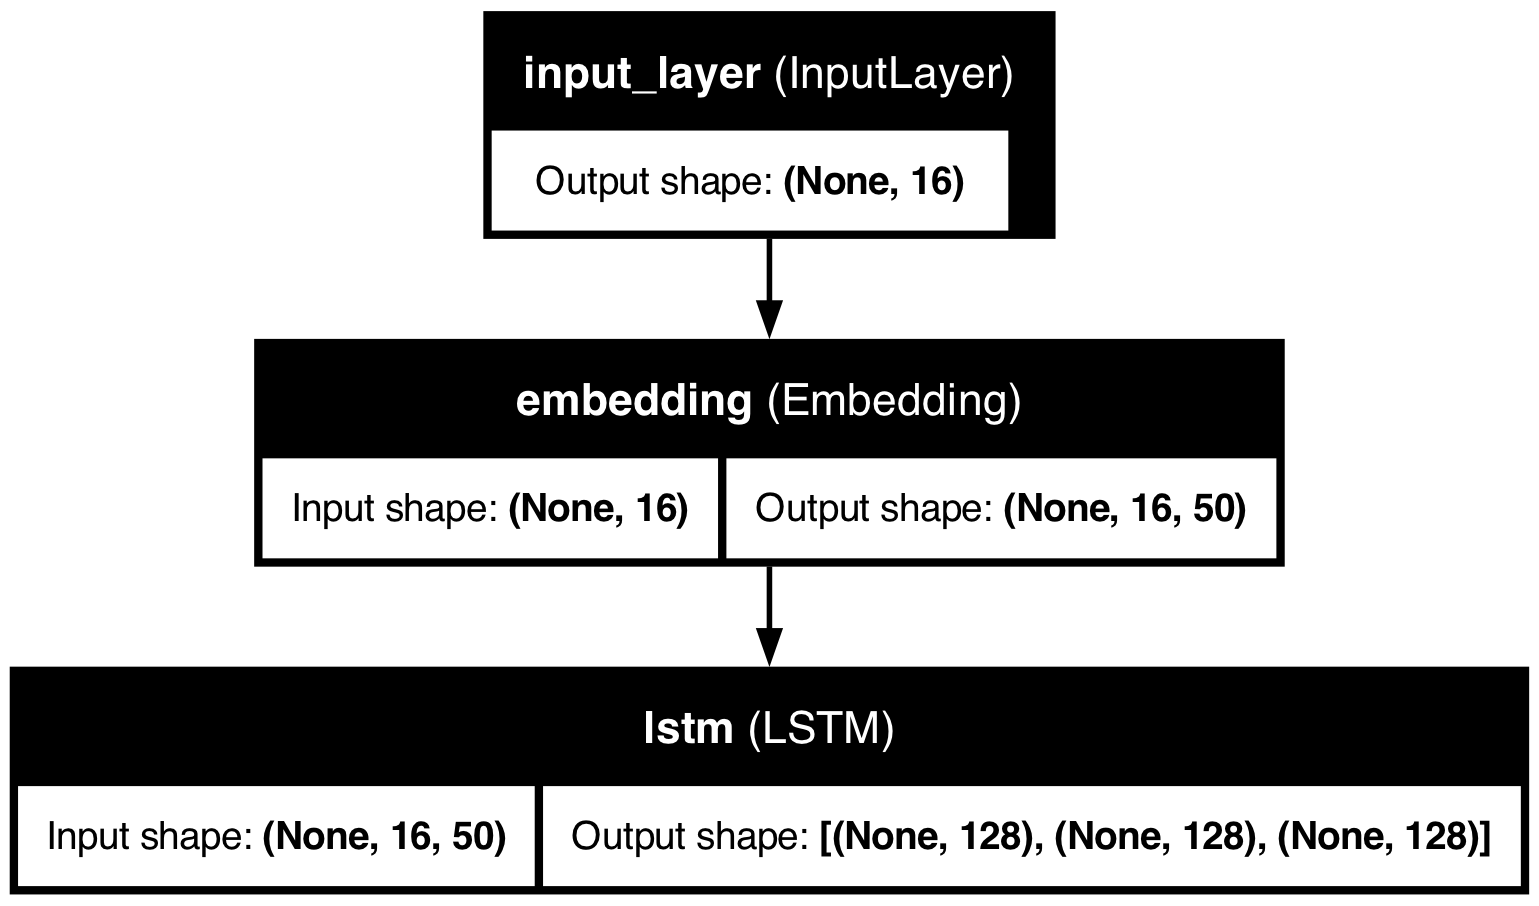

In [22]:
# Modelo solo encoder

# define inference encoder
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

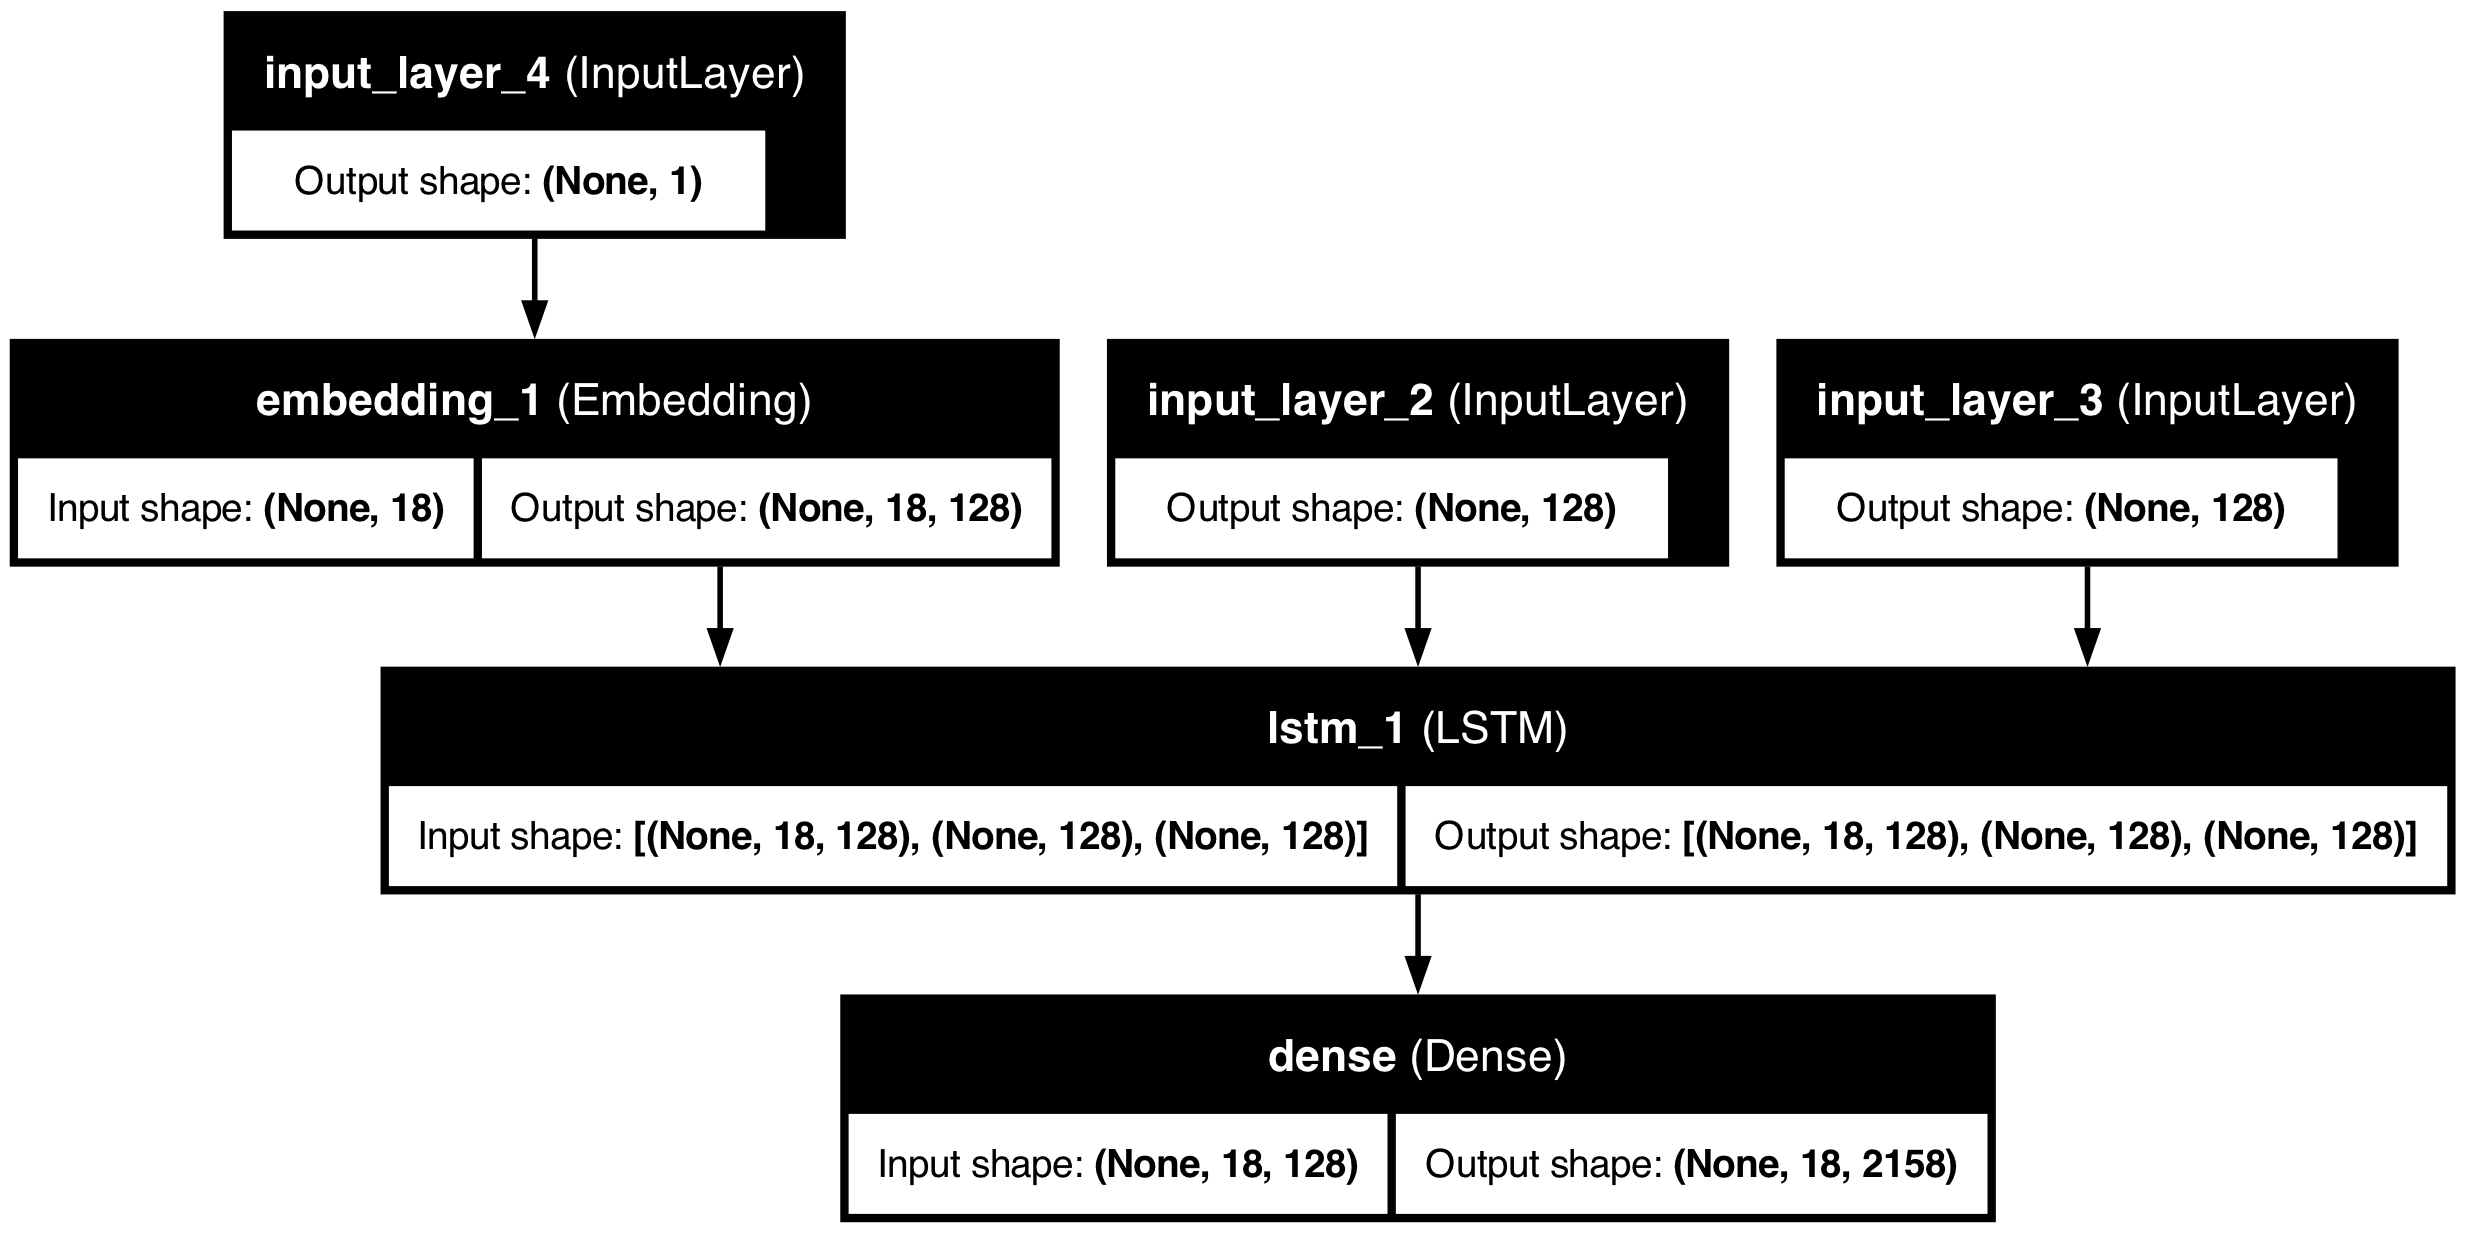

In [23]:
# Modelo solo decoder (para realizar inferencia)

# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# En cada predicción habrá una sola palabra de entrada al decoder,
# que es la realimentación de la palabra anterior
# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [24]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=15, 
    validation_split=0.2)

Epoch 1/15
150/151 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6969 - loss: 3.4537

2024-10-20 08:48:20.331968: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: indices[14,15] = 2157 is not in [0, 2157)
	 [[{{node functional_1/embedding_1/GatherV2}}]]


InvalidArgumentError: Graph execution error:

Detected at node functional_1/embedding_1/GatherV2 defined at (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/runpy.py", line 198, in _run_module_as_main

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/runpy.py", line 88, in _run_code

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/var/folders/gw/t67cp6p50lzcywhjff14xsz00000gn/T/ipykernel_98752/3895294478.py", line 1, in <module>

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 345, in fit

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 433, in evaluate

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 165, in one_step_on_iterator

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 154, in one_step_on_data

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/trainer.py", line 82, in test_step

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/models/functional.py", line 175, in call

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/models/functional.py", line 560, in call

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py", line 140, in call

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/ops/numpy.py", line 4918, in take

  File "/Users/eMinus1db/Documents/Python_Labs/sandbox_ai/sandbox_ai_env/lib/python3.11/site-packages/keras/src/backend/tensorflow/numpy.py", line 1967, in take

indices[14,15] = 2157 is not in [0, 2157)
	 [[{{node functional_1/embedding_1/GatherV2}}]] [Op:__inference_one_step_on_iterator_5826]